In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
img_df = pd.read_csv("photos/image_labels.csv")
img_df.head()

,path,class,label,image_id
0,one_0.jpg,one,0,11
1,one_1.jpg,one,0,11
2,one_2.jpg,one,0,11
3,one_3.jpg,one,0,11
4,one_4.jpg,one,0,11


### Resize images

In [6]:
from PIL import Image

(new_width, new_height) = (128, 128)

path = "photos/original/"
filenames = img_df["path"]

for filename in filenames:
    with Image.open(f"{path}/{filename}") as im:
        width, height = im.size
        if height >= width:
            left = 0
            top = (height-width)/2
            right = width
            bottom = width+(height-width)/2
        else:
            left = (width-height)/2
            top = 0
            right = height+(width-height)/2
            bottom = height
        im_cropped = im.crop((left, top, right, bottom))
        im_resized = im_cropped.resize((new_width, new_height), resample=Image.HAMMING)
        im_resized.save(f"photos/resized/{filename}")

### Create dataset

In [7]:
filenames = img_df["path"]
labels = img_df["label"]
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

filenames = tf.constant(filenames)
labels = tf.constant(labels)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

def im_file_to_tensor(file, label):
    def _im_file_to_tensor(file, label):
        path = f"photos/resized/{file.numpy().decode()}"
        image_decoded = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        im = tf.cast(image_decoded, tf.float32) / 255.0
        return im, label
    return tf.py_function(_im_file_to_tensor, 
                          inp=(file, label), 
                          Tout=(tf.float32, tf.int64))

dataset = dataset.map(im_file_to_tensor)

In [10]:
len(dataset)

310

In [11]:
dataset = dataset.shuffle(310)

Text(0.5, 1.0, 'up_arrow')

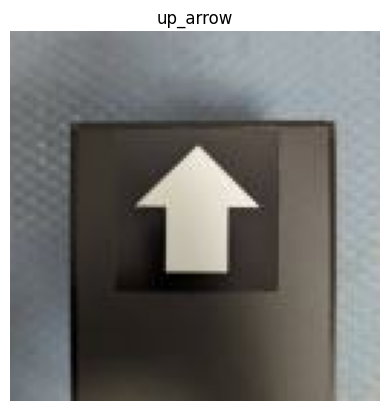

In [15]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.axis("off")
plt.title(classes[label])

### Data augmentation

In [16]:
img_height = 128
img_width = 128

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.45, fill_mode="constant"),
    layers.RandomRotation(0.01, fill_mode="constant"),
    layers.RandomBrightness(0.001),
    layers.RandomContrast(0.5)
  ]
)

Text(0.5, 1.0, 'Alphabet_A')

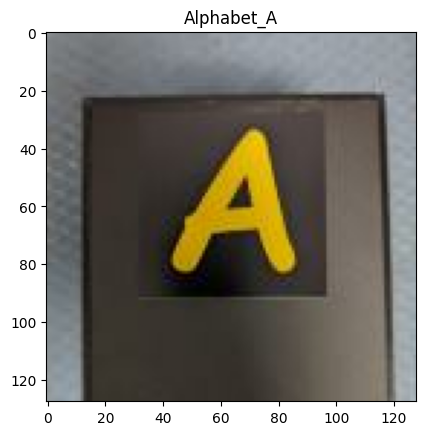

In [19]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.title(classes[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


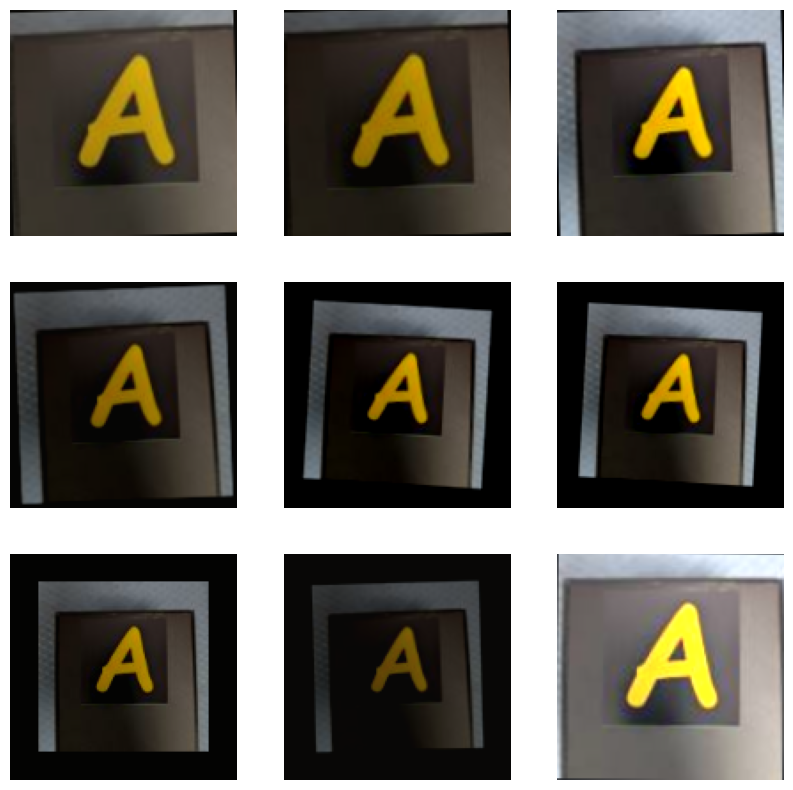

In [21]:
plt.figure(figsize=(10, 10))
for i in range(9):
  new_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(new_image)
  plt.axis("off")

In [70]:
new_images = tf.reshape(tf.constant([], dtype=tf.dtypes.float32), (0, 128, 128, 3))
new_labels = tf.reshape(tf.constant([], dtype=tf.dtypes.int64), (0))

for i in range(10):
    print(f"Iteration {i+1}")
    for image, label in dataset:
        new_image = data_augmentation(image)
        new_images = tf.concat([new_images,  tf.expand_dims(new_image, 0)], axis=0)
        new_labels = tf.concat([new_labels, tf.expand_dims(label, 0)], axis=0)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


In [71]:
add_dataset = tf.data.Dataset.from_tensor_slices((new_images, new_labels))

In [72]:
len(add_dataset)

3100

In [77]:
add_dataset_iter = iter(add_dataset)

Text(0.5, 1.0, 'left_arrow')

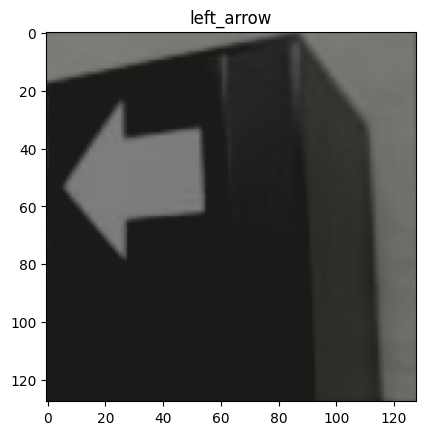

In [87]:
image, label = next(add_dataset_iter)
plt.imshow(image)
plt.title(classes[label])

In [88]:
#Join to original dataset
full_dataset = dataset.concatenate(add_dataset)

print(len(full_dataset))

3410


### Train-test-val split

In [89]:
full_dataset = full_dataset.shuffle(3410)

In [90]:
val_size = test_size = int(0.1*len(full_dataset))
train_size = len(full_dataset) - val_size - test_size

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

print(len(train_dataset), len(val_dataset), len(test_dataset))

2728 341 341


In [96]:
#check if all datasets contain all classes
train_labels = []
for image, label in train_dataset:
    train_labels.append(int(label))

print(len(np.unique(train_labels)))

val_labels = []
for image, label in val_dataset:
    val_labels.append(int(label))

print(len(np.unique(val_labels)))

test_labels = []
for image, label in test_dataset:
    test_labels.append(int(label))

print(len(np.unique(test_labels)))

31
31
31


In [97]:
batch_size = 32

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### CNN

In [158]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.45, fill_mode="constant"),
    layers.RandomRotation(0.01, fill_mode="constant"),
    layers.RandomBrightness(0.001),
    layers.RandomContrast(0.5)
  ]
)

In [159]:
cnn_model = Sequential([
  data_augmentation,
  layers.DepthwiseConv2D(3, 3, padding='same', depth_multiplier=2, activation='relu'),
  layers.MaxPooling2D(2, 1),
  layers.DepthwiseConv2D(3, 3, padding='same', depth_multiplier=2, activation='relu'),
  layers.MaxPooling2D(2, 1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(classes))
])

In [160]:
optimizer = keras.optimizers.AdamW(learning_rate=0.001)

In [161]:
cnn_model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

cnn_model.build((None, 128, 128, 3))

In [162]:
cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 depthwise_conv2d_18 (Depth  (None, 43, 43, 6)         60        
 wiseConv2D)                                                     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 42, 42, 6)         0         
 ng2D)                                                           
                                                                 
 depthwise_conv2d_19 (Depth  (None, 14, 14, 12)        120       
 wiseConv2D)                                                     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 13, 13, 12)        0         
 ng2D)                                               

In [163]:
epochs = 20

history = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20


ValueError: in user code:

    File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'sequential_13' (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received by layer 'sequential_13' (type Sequential):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=True
      • mask=None
